In [1]:
import os

import pandas as pd

from d_2021.config.path import *
from d_2021.utils.import_utils import *
from d_2021.utils.math_utils import *
from d_2021.utils.common_utils import *
from tqdm import *

In [2]:
def data_pre_threat():
    if os.path.exists(md_df_path):
        md_df_3 = pd.read_csv(md_df_path)
        md_names = md_df_3.columns.tolist()
    else:
        md_names, md_df = get_objs_in_csv("../../dataset/train/Molecular_Descriptor.csv")
        print('总特征数:', len(md_names) - 1)
        error_names = []
        # 使用箱线法去除异常值出现大于100次的列
        for md_name in md_names[1:]:
            row = md_df[md_name].tolist()
            # row = str_list_2_int(row)
            min_num, Q1, Q2, Q3, max_num = get_box_plot(row, md_name, False)
            # 计算异常值数量
            error_count = 0
            for i in range(len(row)):
                cell = md_df[md_name][i]
                if cell < min_num:
                    error_count += 1
                    md_df.loc[i, md_name] = min_num
                if cell > max_num:
                    error_count += 1
                    md_df.loc[i, md_name] = max_num
            if error_count > 100:
                error_names.append(md_name)
        print('异常值数量:', len(error_names))
        md_df_2 = remove_names(md_df, md_names, error_names)
        # 含0大于0.9的列
        zero_names = []
        # 计算列内含0大于90%的列
        for md_name in md_names[1:]:
            row = md_df_2[md_name]
            p = count_zero(row)
            if p > 0.9:
                zero_names.append(md_name)
        print('0值大于90%数量:', len(zero_names))
        md_df_3 = remove_names(md_df_2, md_names, zero_names)
        print('筛选后总数', len(md_names) - 1)
        md_df_3.to_csv(md_df_path, index=False)
    return md_df_3, md_names

# 一、 数据清洗
## 1. 去除异常值 2. 去除0多的值

In [3]:
# 预处理后的Molecular_Descriptor

print('===================第一步==================')
print('数据清洗 1. 去除异常值 2. 去除0多的值')
pre_threat_df, pre_threat_names = data_pre_threat()
print()

===================第一步==================
数据清洗 1. 去除异常值 2. 去除0多的值



# 二、 计算灰色关联度，获取前n个数据

In [4]:
print('===================第二步==================')
print('求灰色关联度')
era_names, era_df = get_objs_in_csv("../../dataset/train/ERa_activity.csv")
p_df = era_df['pIC50']
grey_df = get_gray_relation_dataframe(p_df, pre_threat_df)
top_names = get_relevancy_top(grey_df, 100)

===================第二步==================
求灰色关联度
获取母子序列均值商
计算母子矩阵差值矩阵极值
计算灰色关联度矩阵


100%|██████████| 247/247 [00:00<00:00, 35755.96it/s]


# 三、 使用随机森林筛选重要特征

In [5]:
forest_dataset = pre_threat_df[top_names]
# 将数据放大10000倍，因为不能用float进行训练
forest_dataset = forest_dataset.apply(lambda row: row * 10000, axis=1)
feat_labels = forest_dataset.columns[1:]
x, forest = get_random_forest_result(forest_dataset)
importance = forest.feature_importances_
indices = np.argsort(importance)[::-1]
random_forest_names = []
for f in range(30):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importance[indices[f]]))
    random_forest_names.append(feat_labels[indices[f]])

 1) MAXDP2                         0.016919
 2) gmax                           0.015790
 3) BCUTp-1l                       0.015205
 4) maxHBa                         0.015113
 5) maxaasC                        0.014420
 6) LipoaffinityIndex              0.014181
 7) MDEC-23                        0.014039
 8) CrippenLogP                    0.013946
 9) ETA_EtaP_B_RC                  0.013840
10) maxaaCH                        0.013646
11) maxHaaCH                       0.013578
12) ETA_EtaP                       0.013344
13) minHaaCH                       0.013315
14) WTPT-2                         0.013283
15) minaaCH                        0.013241
16) maxHother                      0.013100
17) minHother                      0.012974
18) maxwHBa                        0.012974
19) ETA_Shape_Y                    0.012967
20) VP-4                           0.012898
21) ATSm5                          0.012814
22) ATSp5                          0.012595
23) SP-7                        

In [6]:
def get_sequence_difference1(s1: pd.Series, s2: pd.Series):
    n = len(s1)
    d = (s1.sort_values().values - s2.sort_values().values) ** 2  #就是排序后的排名方差
    dd = d.to_series().sum()
    p = 1 - n * dd / (n * (n ** 2 - 1))
    return p

In [7]:
spearman_dataset = pre_threat_df[random_forest_names]

In [8]:
import seaborn as sns


def ShowHeatMap(d1, d2, title):
    colormap = plt.cm.RdBu
    ylabels = d2.columns.values.tolist()
    f, ax = plt.subplots(figsize=(18, 16))
    ax.set_title(title)
    sns.heatmap(d1.astype(float),
                cmap=colormap,
                ax=ax,
                annot=True,
                yticklabels=ylabels,
                xticklabels=ylabels)
    plt.show()

In [29]:
rs_obj = {}
n = len(random_forest_names) - 1
result = np.zeros([n, n])
for i in trange(n):
    for j in range(n):
        dataset1 = spearman_dataset[random_forest_names[i]].sort_values()
        dataset2 = spearman_dataset[random_forest_names[j]].sort_values()
        rs = dataset1.corr(dataset2, method='spearman')
        # rs = get_sequence_difference1(dataset1, dataset2)
        if i != j:
            rs_obj[random_forest_names[i] + '@' + random_forest_names[j]] = rs
        result[i, j] = rs
        result[j, i] = rs
r_df = pd.DataFrame(result)

100%|██████████| 29/29 [00:01<00:00, 26.56it/s]


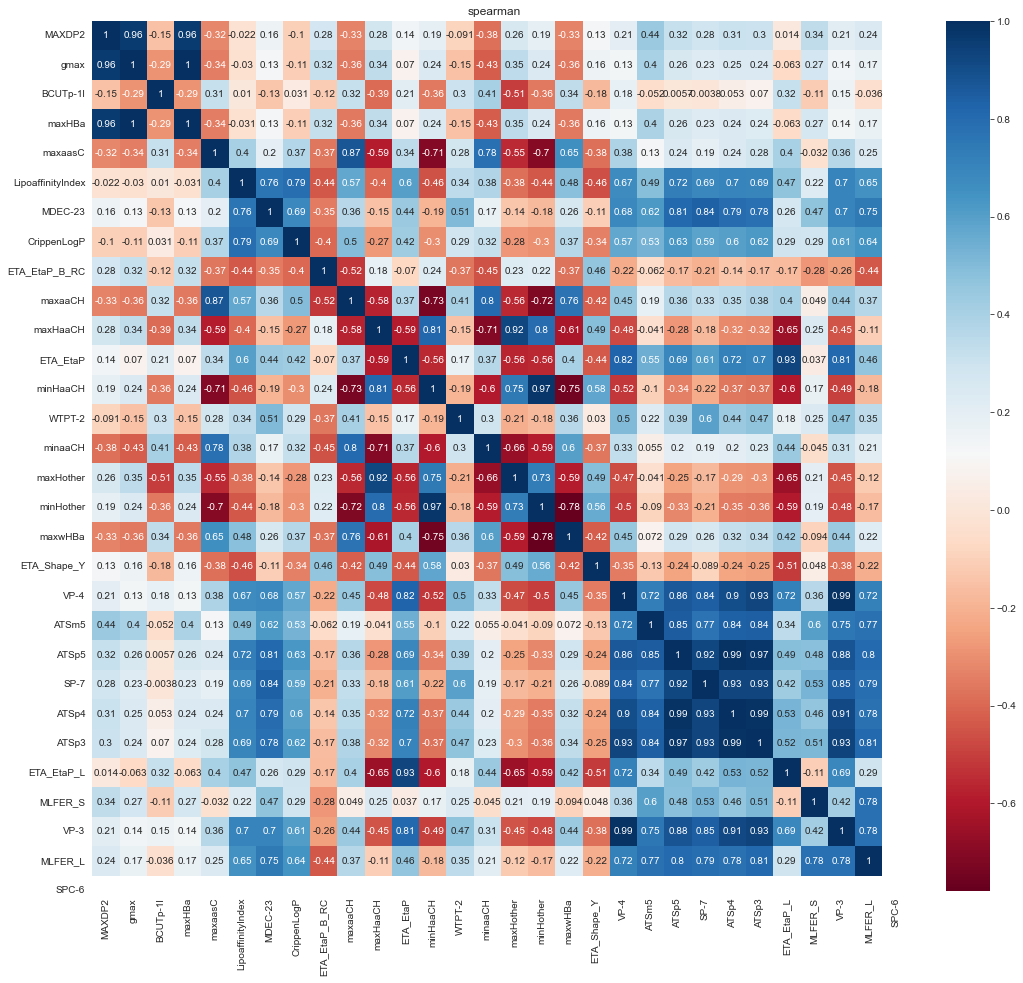

In [30]:
ShowHeatMap(r_df, spearman_dataset, 'spearman')

In [36]:
rs_obj1 = sorted(rs_obj.items(), key=lambda x: x[1], reverse=True)
out_list = []
for obj in rs_obj1:
    if abs(float(obj[1])) > 0.87:
        out_list.append(obj[0])
out_list

['gmax@maxHBa',
 'maxHBa@gmax',
 'VP-4@VP-3',
 'VP-3@VP-4',
 'ATSp4@ATSp3',
 'ATSp3@ATSp4',
 'ATSp5@ATSp4',
 'ATSp4@ATSp5',
 'ATSp5@ATSp3',
 'ATSp3@ATSp5',
 'minHaaCH@minHother',
 'minHother@minHaaCH',
 'gmax@MAXDP2',
 'MAXDP2@gmax',
 'MAXDP2@maxHBa',
 'maxHBa@MAXDP2',
 'ATSp3@VP-3',
 'VP-3@ATSp3',
 'ETA_EtaP@ETA_EtaP_L',
 'ETA_EtaP_L@ETA_EtaP',
 'SP-7@ATSp3',
 'ATSp3@SP-7',
 'ATSp4@SP-7',
 'SP-7@ATSp4',
 'ATSp3@VP-4',
 'VP-4@ATSp3',
 'maxHaaCH@maxHother',
 'maxHother@maxHaaCH',
 'ATSp5@SP-7',
 'SP-7@ATSp5',
 'ATSp4@VP-3',
 'VP-3@ATSp4',
 'VP-4@ATSp4',
 'ATSp4@VP-4',
 'ATSp5@VP-3',
 'VP-3@ATSp5',
 'maxaasC@maxaaCH',
 'maxaaCH@maxaasC']

In [37]:
out_list1 = []
for t in out_list:
    # 获得[x,y]
    tt = t.split('@')
    if tt[0] in out_list1 or tt[1] in out_list1:
        continue
    else:
        out_list1.append(tt[1])
len(out_list1)

10

In [38]:
spearman_list = []
for name in random_forest_names:
    if name in out_list1:
        continue
    else:
        spearman_list.append(name)
len(spearman_list)

20

# 检验

In [42]:
from minepy import MINE

# 把两个列表拼起来
data = pd.concat([pd.DataFrame(p_df), pre_threat_df[spearman_list]], axis=1)
data2 = np.array(data)
data2

array([[ 8.602     ,  9.96894808,  5.24543482, ...,  2.288     ,
        16.311     ,  9.01972914],
       [ 8.125     , 10.05894808,  5.25677025, ...,  2.288     ,
        17.309     ,  9.2554314 ],
       [ 8.509     ,  9.97750801,  4.91013974, ...,  2.901     ,
        17.662     ,  9.76073676],
       ...,
       [ 7.721     , 13.65931654,  4.87756674, ...,  3.901     ,
        21.185     , 17.41232924],
       [ 7.886     , 13.26118827,  4.87740507, ...,  2.841     ,
        15.495     , 14.50789774],
       [ 7.569     , 13.73992275,  4.87752886, ...,  3.627     ,
        21.203     , 17.87158571]])

In [44]:
n = len(data2[0, :])
result = np.zeros([n, n])
for i in trange(n):
    for j in range(n):
        mine = MINE(alpha=0.6, c=15)
        mine.compute_score(data2[:, i], data2[:, j])
        result[i, j] = mine.mic()
        result[j, i] = mine.mic()
r_df = pd.DataFrame(result)
r_df

100%|██████████| 21/21 [01:01<00:00,  2.93s/it]


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.304285,0.288913,0.184869,0.319277,0.339381,0.251364,0.151295,0.193797,0.204456,...,0.186095,0.203654,0.173430,0.157095,0.242046,0.215447,0.288509,0.189240,0.250027,0.241249
1,0.304285,1.000000,0.322922,0.251994,0.361225,0.369645,0.298700,0.244707,0.252221,0.274599,...,0.252009,0.317403,0.279176,0.191995,0.354093,0.384918,0.429415,0.285243,0.344151,0.357013
2,0.288913,0.322922,1.000000,0.310744,0.357073,0.356218,0.313098,0.235526,0.363674,0.342246,...,0.300805,0.337599,0.291227,0.238233,0.349472,0.315402,0.339858,0.283931,0.301985,0.299050
3,0.184869,0.251994,0.310744,1.000000,0.249417,0.218769,0.251579,0.233498,0.514107,0.246066,...,0.218293,0.569183,0.554741,0.246908,0.261412,0.195828,0.197719,0.222089,0.206394,0.168224
4,0.319277,0.361225,0.357073,0.249417,1.000000,0.614001,0.539789,0.292168,0.236132,0.402103,...,0.316914,0.277216,0.290782,0.325984,0.471348,0.349523,0.571450,0.227835,0.482000,0.294344
5,0.339381,0.369645,0.356218,0.218769,0.614001,1.000000,0.481148,0.269550,0.193735,0.340641,...,0.401535,0.225407,0.226281,0.257109,0.527245,0.454378,0.733722,0.337592,0.623279,0.366862
6,0.251364,0.298700,0.313098,0.251579,0.539789,0.481148,1.000000,0.269562,0.215893,0.268658,...,0.286277,0.241201,0.270577,0.270678,0.353586,0.333346,0.451309,0.236498,0.456379,0.206451
7,0.151295,0.244707,0.235526,0.233498,0.292168,0.269550,0.269562,1.000000,0.231650,0.216907,...,0.314146,0.303917,0.293325,0.390844,0.207488,0.195200,0.221847,0.234296,0.308233,0.296265
8,0.193797,0.252221,0.363674,0.514107,0.236132,0.193735,0.215893,0.231650,1.000000,0.354758,...,0.226540,0.671742,0.412921,0.280758,0.269055,0.170489,0.195096,0.244751,0.187164,0.174188
9,0.204456,0.274599,0.342246,0.246066,0.402103,0.340641,0.268658,0.216907,0.354758,1.000000,...,0.297254,0.298449,0.249888,0.281505,0.590660,0.368779,0.465043,0.218890,0.380885,0.377120


100%|██████████| 21/21 [01:00<00:00,  2.87s/it]


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.304285,0.288913,0.184869,0.319277,0.339381,0.251364,0.151295,0.193797,0.204456,...,0.186095,0.203654,0.173430,0.157095,0.242046,0.215447,0.288509,0.189240,0.250027,0.241249
1,0.304285,1.000000,0.322922,0.251994,0.361225,0.369645,0.298700,0.244707,0.252221,0.274599,...,0.252009,0.317403,0.279176,0.191995,0.354093,0.384918,0.429415,0.285243,0.344151,0.357013
2,0.288913,0.322922,1.000000,0.310744,0.357073,0.356218,0.313098,0.235526,0.363674,0.342246,...,0.300805,0.337599,0.291227,0.238233,0.349472,0.315402,0.339858,0.283931,0.301985,0.299050
3,0.184869,0.251994,0.310744,1.000000,0.249417,0.218769,0.251579,0.233498,0.514107,0.246066,...,0.218293,0.569183,0.554741,0.246908,0.261412,0.195828,0.197719,0.222089,0.206394,0.168224
4,0.319277,0.361225,0.357073,0.249417,1.000000,0.614001,0.539789,0.292168,0.236132,0.402103,...,0.316914,0.277216,0.290782,0.325984,0.471348,0.349523,0.571450,0.227835,0.482000,0.294344
5,0.339381,0.369645,0.356218,0.218769,0.614001,1.000000,0.481148,0.269550,0.193735,0.340641,...,0.401535,0.225407,0.226281,0.257109,0.527245,0.454378,0.733722,0.337592,0.623279,0.366862
6,0.251364,0.298700,0.313098,0.251579,0.539789,0.481148,1.000000,0.269562,0.215893,0.268658,...,0.286277,0.241201,0.270577,0.270678,0.353586,0.333346,0.451309,0.236498,0.456379,0.206451
7,0.151295,0.244707,0.235526,0.233498,0.292168,0.269550,0.269562,1.000000,0.231650,0.216907,...,0.314146,0.303917,0.293325,0.390844,0.207488,0.195200,0.221847,0.234296,0.308233,0.296265
8,0.193797,0.252221,0.363674,0.514107,0.236132,0.193735,0.215893,0.231650,1.000000,0.354758,...,0.226540,0.671742,0.412921,0.280758,0.269055,0.170489,0.195096,0.244751,0.187164,0.174188
9,0.204456,0.274599,0.342246,0.246066,0.402103,0.340641,0.268658,0.216907,0.354758,1.000000,...,0.297254,0.298449,0.249888,0.281505,0.590660,0.368779,0.465043,0.218890,0.380885,0.377120


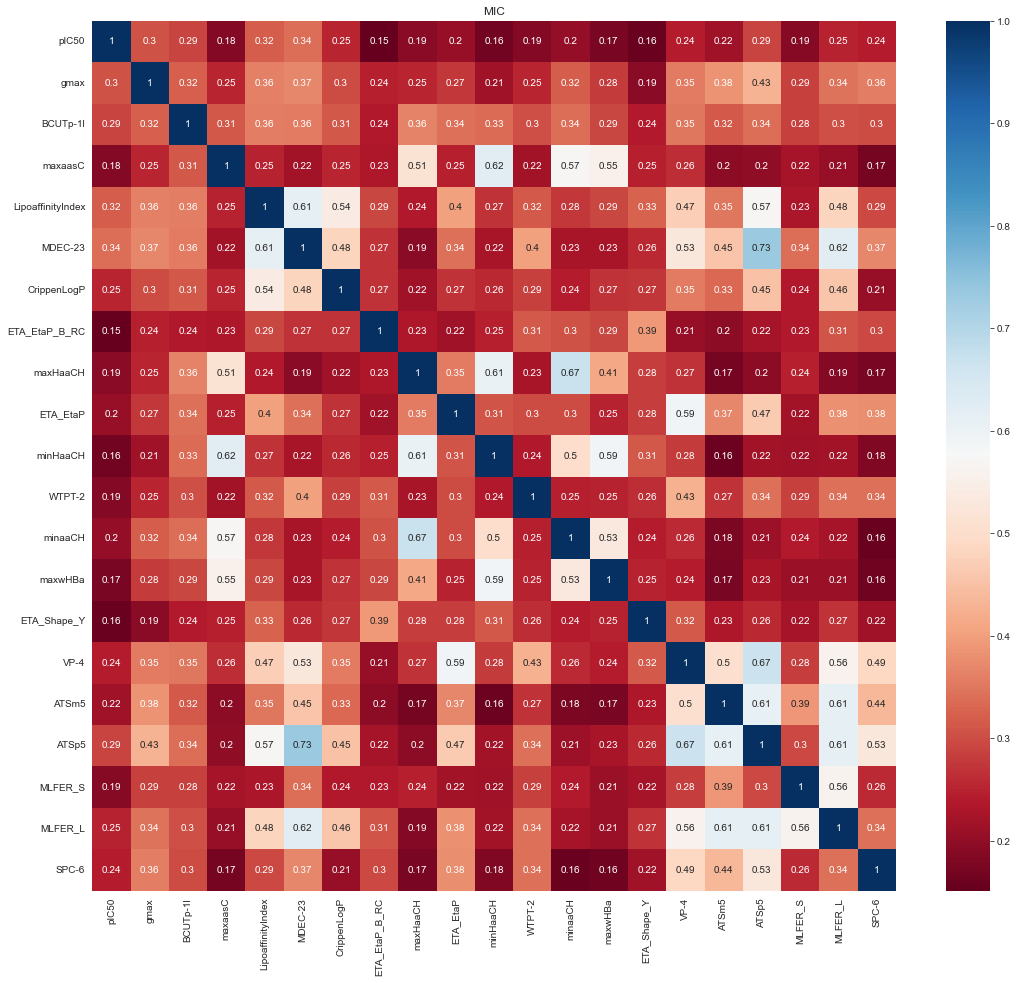

In [45]:
data = pd.concat([pd.DataFrame(p_df), pre_threat_df[spearman_list]], axis=1)
ShowHeatMap(r_df, data, 'MIC')

In [46]:
import dcor

n = len(data2[0, :])
result = np.zeros([n, n])
for i in trange(n):
    for j in range(n):
        result[i, j] = dcor.distance_correlation(data2[:, i], data2[:, j])
        result[j, i] = dcor.distance_correlation(data2[:, j], data2[:, i])
r_df = pd.DataFrame(result)
r_df

100%|██████████| 21/21 [00:04<00:00,  4.81it/s]


,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.249560,0.151086,0.245715,0.514672,0.542488,0.455191,0.188874,0.239819,0.337322,...,0.255085,0.189582,0.223675,0.126659,0.419604,0.359181,0.458841,0.199748,0.381947,0.268592
1,0.249560,1.000000,0.345184,0.344672,0.243727,0.197479,0.263569,0.319191,0.362734,0.147014,...,0.219233,0.443588,0.385008,0.176269,0.163628,0.327241,0.238584,0.275531,0.177594,0.341464
2,0.151086,0.345184,1.000000,0.255849,0.134215,0.198797,0.108121,0.172964,0.335920,0.192365,...,0.296530,0.372699,0.284126,0.173065,0.182899,0.167149,0.171900,0.129943,0.145675,0.149669
3,0.245715,0.344672,0.255849,1.000000,0.413622,0.292928,0.402683,0.389816,0.611076,0.369424,...,0.273356,0.752734,0.680010,0.391935,0.389339,0.203804,0.283953,0.157058,0.302209,0.105167
4,0.514672,0.243727,0.134215,0.413622,1.000000,0.759574,0.763553,0.421292,0.393747,0.593942,...,0.354950,0.350185,0.481406,0.461272,0.654845,0.501372,0.724458,0.263862,0.663143,0.389251
5,0.542488,0.197479,0.198797,0.292928,0.759574,1.000000,0.681494,0.356317,0.219046,0.461011,...,0.492939,0.227573,0.322335,0.263501,0.672787,0.631369,0.813607,0.473365,0.767344,0.500741
6,0.455191,0.263569,0.108121,0.402683,0.763553,0.681494,1.000000,0.384287,0.306104,0.421124,...,0.299271,0.331729,0.395389,0.353148,0.549655,0.514908,0.611555,0.299173,0.639096,0.275284
7,0.188874,0.319191,0.172964,0.389816,0.421292,0.356317,0.384287,1.000000,0.257003,0.182179,...,0.372425,0.481129,0.407725,0.471582,0.237217,0.142602,0.211848,0.294006,0.432706,0.293569
8,0.239819,0.362734,0.335920,0.611076,0.393747,0.219046,0.306104,0.257003,1.000000,0.573126,...,0.212014,0.710388,0.598330,0.471369,0.463913,0.137984,0.311908,0.279418,0.179154,0.187790
9,0.337322,0.147014,0.192365,0.369424,0.593942,0.461011,0.421124,0.182179,0.573126,1.000000,...,0.248521,0.362343,0.405838,0.427742,0.807380,0.551915,0.692164,0.264806,0.495273,0.596819


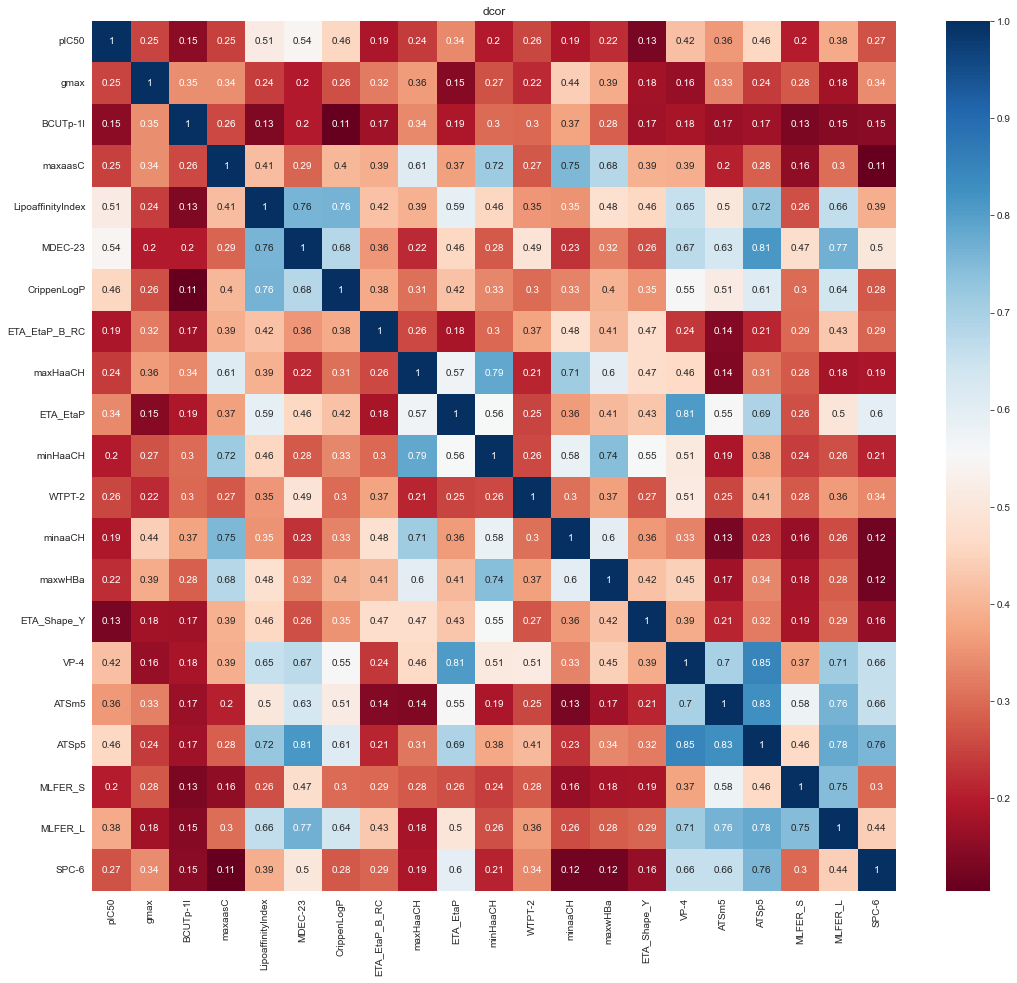

In [47]:
ShowHeatMap(r_df, data, 'dcor')

In [50]:
import shap

x, y = pd.DataFrame(p_df), pre_threat_df[spearman_list]
forest_model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
forest_model.fit(x, y.astype('int'))

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: RandomForestClassifier(n_jobs=-1, random_state=0)

In [51]:
explainer = shap.TreeExplainer(forest_model)
shap_values = explainer(x)
shap.summary_plot(shap_values, x)

MemoryError: Unable to allocate 380. MiB for an array with shape (1649, 30220) and data type float64